In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim

from geomloss import SamplesLoss

import numpy as np
import pandas as pd

import sklearn.preprocessing, sklearn.decomposition
import umap

from types import SimpleNamespace

import joblib
import json
import os
import random
import sys

In [2]:
from tqdm.notebook import tqdm

In [3]:
sys.path.append("../src")

%load_ext autoreload
%autoreload 2

import train as this

import spring_helper as sh

In [4]:
import sklearn.decomposition
import umap

import scipy.io
import scipy.sparse

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import annoy

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

# Raw data

In [8]:
expr = sh.load_npz("/data/gl/g2/sachit/data/klein/processed/counts_matrix_in_vitro.npz")
genes = sh.load_genes("/data/gl/g2/sachit/data/klein/processed/gene_names_in_vitro.txt")
#non_mito = [name for name in df.columns if not name.startswith('mt-')]
highly_variable_genes = sh.filter_genes(expr)
cell_cycle_genes = [['Ube2c',
                    'Hmgb2',
                    'Hmgn2',
                    'Tuba1b', 
                    'Ccnb1', 
                    'Tubb5', 
                    'Top2a', 
                    'Tubb4b']]
non_cell_cycle_idx = sh.remove_corr_genes(expr, gene_list=genes, exclude_corr_genes_list=cell_cycle_genes, test_gene_idx=highly_variable_genes, min_corr=0.1)
non_cell_cycle_idx = non_cell_cycle_idx[0:2447]
# perform filtering
expr = expr[:, non_cell_cycle_idx]

In [9]:
use_genes = [genes[i] for i in non_cell_cycle_idx]

Clonal data

In [10]:
base_dir = "../ext/klein_Figure5_data_and_code/"

timepoints = np.load(base_dir + 'timepoints.npy')
clonal_annotations = scipy.sparse.load_npz("/data/gl/g2/sachit/data/klein/processed/clone_annotation_in_vitro.npz")

In [11]:
day2_clones = clonal_annotations[timepoints == 2,:].sum(axis = 0) > 0
num_daughters = clonal_annotations[:,np.asarray(day2_clones)[0]].sum(axis = 0)
num_daughters = np.asarray(num_daughters)[0]
len(num_daughters)

2672

# Data

In [12]:
pt = torch.load("../data/Weinreb2020_fate/fate_train.pt")

In [13]:
meta = pt['meta']
meta.head()

,Time point,Population,Annotation,Well,numeric_annotation
0,6.0,LK,undiff,2,1
1,6.0,LK,undiff,2,1
2,6.0,LK,Monocyte,2,2
3,6.0,LK,Neutrophil,2,3
4,6.0,LK,undiff,2,1


In [14]:
xp_ = pt['xp']
xu_ = pt['xu']

In [15]:
x_ = pt['data']

In [16]:
seed = 0
np.random.seed(0)

pca = sklearn.decomposition.PCA(n_components = 50)
xp = pca.fit_transform(pt['data'])

# Number of descendants, masked

In [17]:
meta_ = meta.copy()
meta_['clone'] = np.asarray(np.argmax(clonal_annotations, axis = 1))[:,0]
meta_.loc[np.asarray(clonal_annotations.sum(axis = 1) == 0)[:,0], 'clone'] = -1

meta_.head()

,Time point,Population,Annotation,Well,numeric_annotation,clone
0,6.0,LK,undiff,2,1,573
1,6.0,LK,undiff,2,1,1440
2,6.0,LK,Monocyte,2,2,394
3,6.0,LK,Neutrophil,2,3,-1
4,6.0,LK,undiff,2,1,1972


For each clone, compute the number of cells at each time point

In [18]:
nc = meta_.loc[meta_['clone'] != -1]
nc = nc.groupby(['clone'])['Time point'].value_counts().unstack().fillna(0).astype(int)
nc.head()

Time point,2.0,4.0,6.0
clone,,,
0,0,2,3
1,0,13,7
2,1,14,5
3,0,2,0
4,0,3,6


Compute mask to select only cells that are part of a clone

In [19]:
d2_meta = meta_.loc[meta_['Time point'] == 2]
d2_mask = (d2_meta['clone'] > -1).values

d4_meta = meta_.loc[meta_['Time point'] == 4]
d4_mask = (d4_meta['clone'] > -1).values

d6_meta = meta_.loc[meta_['Time point'] == 6] 
d6_mask = (d6_meta['clone'] > -1).values

Since the number of descendants is given by 

$$n = \exp(dt * (b-d))$$

Then,

$$b-d = \frac{\log n}{dt}$$

Adding a pseudocount, get the number of cells for each clone at each time point

Which we can then visualize

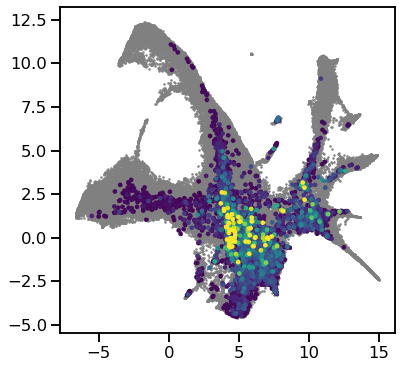

In [21]:
d2_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 2.0].values + 1
d4_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 4.0].values + 1
d6_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 6.0].values + 1

fig, ax = plt.subplots(figsize = (6, 6))
for i in range(len(xu_)): 
    ax.scatter(xu_[i][:,0], xu_[i][:,1], s = 1, color = 'gray')

u = xu_[0][d2_mask]
c = d4_num / d2_num
ix = np.argsort(c)

ax.scatter(u[ix,0], u[ix,1], s = 10, c = c[ix], vmax = 8)

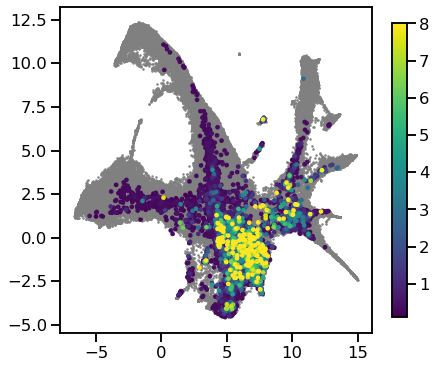

In [46]:
d2_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 2.0].values + 1
d4_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 4.0].values + 1
d6_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 6.0].values + 1

fig, ax = plt.subplots(figsize = (7, 6))
for i in range(len(xu_)): 
    ax.scatter(xu_[i][:,0], xu_[i][:,1], s = 1, color = 'gray')

u = xu_[0][d2_mask]
c = d6_num / d2_num
ix = np.argsort(c)

sax = ax.scatter(u[ix,0], u[ix,1], s = 10, c = c[ix], vmax = 8)
plt.colorbar(sax, shrink = 0.9)

We can calculate the growth rate

In [23]:
d2_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 2.0].values + 1
d4_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 4.0].values + 1
d6_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 6.0].values + 1

d24_num = d4_num / d2_num
d26_num = d6_num / d2_num

d24_growth = np.log(d24_num) / 2
d26_growth = np.log(d26_num) / 4

d4_num = nc.loc[d4_meta.loc[d4_mask, 'clone'], 4.0].values + 1
d6_num = nc.loc[d4_meta.loc[d4_mask, 'clone'], 6.0].values + 1

d46_growth = np.log(d6_num / d4_num) / 2

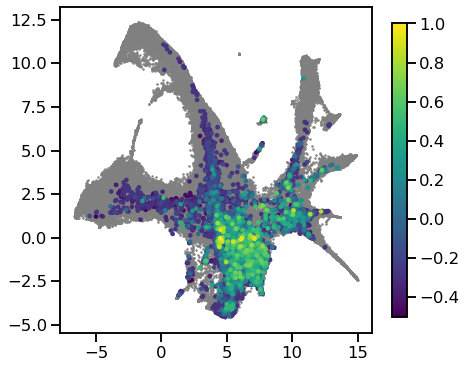

In [75]:
d2_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 2.0].values + 1
d4_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 4.0].values + 1
d6_num = nc.loc[d2_meta.loc[d2_mask, 'clone'], 6.0].values + 1

fig, ax = plt.subplots(figsize = (7, 6))
for i in range(len(xu_)): 
    ax.scatter(xu_[i][:,0], xu_[i][:,1], s = 1, color = 'gray')

u = xu_[0][d2_mask]
c = d26_growth
ix = np.argsort(c)

sax = ax.scatter(u[ix,0], u[ix,1], s = 10, c = c[ix], vmin = -0.5, vmax = 1)
plt.colorbar(sax, shrink = 0.9)

Save to disk

In [39]:
torch.save({
    'm': [d2_mask, d4_mask, d6_mask], 
    'w': [d26_growth, d46_growth, np.ones(d6_mask.sum())],
}, "../../../data/Weinreb2020_growth-d26.pt")

In [40]:
torch.save({
    'm': [d2_mask, d4_mask, d6_mask], 
    'w': [np.ones(d2_mask.sum()), np.ones(d4_mask.sum()), np.ones(d6_mask.sum())], 
}, "../../../data/Weinreb2020_growth-none.pt")

# Compare hallmark vs. kegg annotations

In [47]:
gst = pd.read_csv("./depr/grace/growth/birth_msigdb_hallmark.csv", index_col = 0)
gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]
b1 = x_[gst].mean(axis = 1)

gst = pd.read_csv("./depr/grace/growth/birth_msigdb_kegg.csv", index_col = 0)
gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]
b2 = x_[gst].mean(axis = 1)

scipy.stats.pearsonr(b1, b2)

(0.42880308993995564, 0.0)

In [48]:
gst = pd.read_csv("./depr/grace/growth/death_msigdb_hallmark.csv", index_col = 0)
gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]
d1 = x_[gst].mean(axis = 1)

gst = pd.read_csv("./depr/grace/growth/death_msigdb_kegg.csv", index_col = 0)
gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]
d2 = x_[gst].mean(axis = 1)

scipy.stats.pearsonr(d1, d2)

(0.3808880875031107, 0.0)

# Final model

## Hallmark annotations

In [49]:
gst = pd.read_csv("./depr/grace/growth/birth_msigdb_hallmark.csv", index_col = 0)
birth_gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]

gst = pd.read_csv("./depr/grace/growth/death_msigdb_hallmark.csv", index_col = 0)
death_gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]

birth_gst = [g for g in birth_gst if g not in death_gst]
death_gst = [g for g in death_gst if g not in birth_gst]

Compute scores and smooth over dataset

In [50]:
ay = annoy.AnnoyIndex(xp.shape[1], 'euclidean') 
for i in range(xp.shape[0]):
    ay.add_item(i, xp[i])
ay.build(10)

True

In [51]:
n_neighbors = 20
beta = 0.1

# smooth growth score

prev_score = x_[birth_gst].mean(axis = 1).values
cur_score = np.zeros(prev_score.shape)

for _ in range(5): 
    for i in range(len(prev_score)): 
        xn = prev_score[ay.get_nns_by_item(i, 20)]
        cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
    prev_score = cur_score
    
birth_score = x_[birth_gst].mean(axis = 1).values
birth_smoothed_score = cur_score

# smooth death score

prev_score = x_[death_gst].mean(axis = 1).values
cur_score = np.zeros(prev_score.shape)

for _ in range(5): 
    for i in range(len(prev_score)): 
        xn = prev_score[ay.get_nns_by_item(i, 20)]
        cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
    prev_score = cur_score
    
death_score = x_[death_gst].mean(axis = 1).values  
death_smoothed_score = cur_score

In [49]:
L0 = 0.3
L = 1.1
k = 0.001

kb = np.log(k) / np.min(birth_score)
kd = np.log(k) / np.min(death_score)

b = birth_score[timepoints == 2][d2_mask]
d = death_score[timepoints == 2][d2_mask]

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

d24_num.min(), d24_num.max(), np.exp(2*g.min()), np.exp(2*g.max()), scipy.stats.pearsonr(g, d24_growth)
d26_num.min(), d26_num.max(), np.exp(4*g.min()), np.exp(4*g.max()), scipy.stats.pearsonr(g, d26_growth)

(0.1111111111111111,
 79.0,
 0.012331425013607579,
 81.09361837716237,
 (0.11868539017880879, 5.090703101773256e-16))

In [50]:
L0 = 0.3
L = 1.1
k = 0.001

kb = np.log(k) / np.min(birth_smoothed_score)
kd = np.log(k) / np.min(death_smoothed_score)

b = birth_smoothed_score[timepoints == 2][d2_mask]
d = death_smoothed_score[timepoints == 2][d2_mask]

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

d24_num.min(), d24_num.max(), np.exp(2*g.min()), np.exp(2*g.max()), scipy.stats.pearsonr(g, d24_growth)
d26_num.min(), d26_num.max(), np.exp(4*g.min()), np.exp(4*g.max()), scipy.stats.pearsonr(g, d26_growth)

(0.1111111111111111,
 79.0,
 0.014047239408340538,
 78.50308916658184,
 (0.22999658395544853, 9.832917810952042e-57))

In [51]:
L0 = 0.3
L = 1.1
k = 0.001

kb = np.log(k) / np.min(birth_smoothed_score)
kd = np.log(k) / np.min(death_smoothed_score)

b = birth_smoothed_score
d = death_smoothed_score

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

In [52]:
torch.save({
    'm': [d2_mask, d4_mask, d6_mask], 
    'w': [g[timepoints == 2][d2_mask], g[timepoints == 4][d4_mask], g[timepoints == 6][d6_mask]], 
}, "../data/Weinreb2020_growth-hallmark.pt")

In [453]:
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

b = beta(birth_smoothed_score[timepoints == 2][d2_mask], beta_max = 1.1)
d = delta(death_smoothed_score[timepoints == 2][d2_mask], delta_max = 1.1)
g = b - d

L, scipy.stats.pearsonr(g, d24_growth), scipy.stats.pearsonr(g, d26_growth)

(1.1,
 (0.07791362069021969, 1.0796076170382465e-07),
 (0.12427320451370133, 1.996023451851622e-17))

## KEGG annotations

In [52]:
gst = pd.read_csv("./depr/grace/growth/birth_msigdb_kegg.csv", index_col = 0)
birth_gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]

gst = pd.read_csv("./depr/grace/growth/death_msigdb_kegg.csv", index_col = 0)
death_gst = [g for g in gst['gene_symbol'].unique() if g in use_genes]

birth_gst = [g for g in birth_gst if g not in death_gst]
death_gst = [g for g in death_gst if g not in birth_gst]

In [53]:
n_neighbors = 20
beta = 0.1

# smooth growth score

prev_score = x_[birth_gst].mean(axis = 1).values
cur_score = np.zeros(prev_score.shape)

for _ in range(5): 
    for i in range(len(prev_score)): 
        xn = prev_score[ay.get_nns_by_item(i, 20)]
        cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
    prev_score = cur_score
    
birth_score = x_[birth_gst].mean(axis = 1).values
birth_smoothed_score = cur_score

# smooth death score

prev_score = x_[death_gst].mean(axis = 1).values
cur_score = np.zeros(prev_score.shape)

for _ in range(5): 
    for i in range(len(prev_score)): 
        xn = prev_score[ay.get_nns_by_item(i, 20)]
        cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
    prev_score = cur_score
    
death_score = x_[death_gst].mean(axis = 1).values  
death_smoothed_score = cur_score

In [54]:
L0 = 0.3
L = 1.1
k = 0.001

kb = np.log(k) / np.min(birth_score)
kd = np.log(k) / np.min(death_score)

b = birth_score[timepoints == 2][d2_mask]
d = death_score[timepoints == 2][d2_mask]

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

d24_num.min(), d24_num.max(), np.exp(2*g.min()), np.exp(2*g.max()), scipy.stats.pearsonr(g, d24_growth)
d26_num.min(), d26_num.max(), np.exp(4*g.min()), np.exp(4*g.max()), scipy.stats.pearsonr(g, d26_growth)

(0.1111111111111111,
 79.0,
 0.012331425013604468,
 81.09362858686359,
 (0.0059699047180441405, 0.6844034381686096))

Smoothing yields better correlation

In [61]:
L0 = 0.3
L = 1.2
k = 0.001

kb = np.log(k) / np.min(birth_smoothed_score)
kd = np.log(k) / np.min(death_smoothed_score)

b = birth_smoothed_score[timepoints == 2][d2_mask]
d = death_smoothed_score[timepoints == 2][d2_mask]

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

d24_num.min(), d24_num.max(), np.exp(2*g.min()), np.exp(2*g.max()), scipy.stats.pearsonr(g, d24_growth), d26_num.min(), d26_num.max(), np.exp(4*g.min()), np.exp(4*g.max()), scipy.stats.pearsonr(g, d26_growth)

(0.14285714285714285,
 20.0,
 0.09396303886458347,
 9.090510591943731,
 (0.24443337159884948, 4.568581536682464e-64),
 0.1111111111111111,
 79.0,
 0.008829052672667223,
 82.63738282224116,
 (0.20705925180559842, 4.340909446765582e-46))

(0.20705925180559842, 4.340909446765582e-46)

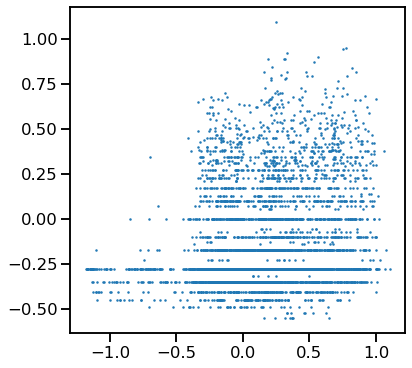

In [78]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.scatter(g, d26_growth, s = 1)
scipy.stats.pearsonr(g, d26_growth)

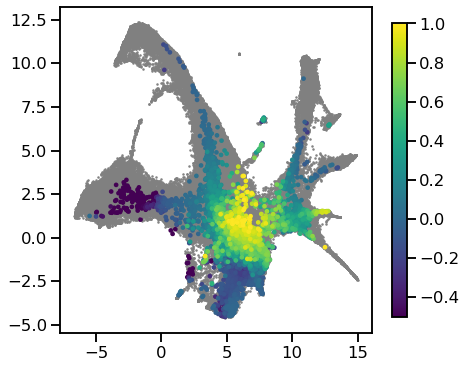

In [74]:
fig, ax = plt.subplots(figsize = (7, 6))
for i in range(len(xu_)): 
    ax.scatter(xu_[i][:,0], xu_[i][:,1], s = 1, color = 'gray')

u = xu_[0][d2_mask]
c = g
ix = np.argsort(c)

sax = ax.scatter(u[ix,0], u[ix,1], s = 10, c = c[ix], vmin = -0.5, vmax = 1)
plt.colorbar(sax, shrink = 0.9)

With mask

In [57]:
L0 = 0.3
L = 1.2
k = 0.001

kb = np.log(k) / np.min(birth_smoothed_score)
kd = np.log(k) / np.min(death_smoothed_score)

b = birth_smoothed_score
d = death_smoothed_score

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

torch.save({
    'm': [d2_mask, d4_mask, d6_mask], 
    'w': [g[timepoints == 2][d2_mask], g[timepoints == 4][d4_mask], g[timepoints == 6][d6_mask]], 
}, "../data/Weinreb2020_growth-kegg.pt")

No mask i.e. all available cells

In [30]:
L0 = 0.3
L = 1.2
k = 0.001

kb = np.log(k) / np.min(birth_smoothed_score)
kd = np.log(k) / np.min(death_smoothed_score)

b = birth_smoothed_score
d = death_smoothed_score

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

torch.save({
    'm': [[True]*len(d2_mask), [True]*len(d4_mask), [True]*len(d6_mask)], 
    'w': [g[timepoints == 2], g[timepoints == 4], g[timepoints == 6]], 
}, "../data/Weinreb2020_growth-all_kegg.pt")

In [33]:
d2_mask.sum() / len(d2_mask) * 0.1

0.016418280293107722

Inverted mask

In [27]:
L0 = 0.3
L = 1.2
k = 0.001

kb = np.log(k) / np.min(birth_smoothed_score)
kd = np.log(k) / np.min(death_smoothed_score)

b = birth_smoothed_score
d = death_smoothed_score

b = L0 + L / (1 + np.exp(-kb * b))
d = L0 + L / (1 + np.exp(-kd * d))
g = b - d

torch.save({
    'm': [~d2_mask, ~d4_mask, ~d6_mask], 
    'w': [g[timepoints == 2][~d2_mask], g[timepoints == 4][~d4_mask], g[timepoints == 6][~d6_mask]], 
}, "../data/Weinreb2020_growth-heldout_kegg.pt")

In [461]:
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

b = beta(birth_smoothed_score[timepoints == 2][d2_mask], beta_max = 1.2)
d = delta(death_smoothed_score[timepoints == 2][d2_mask], delta_max = 1.2)
g = b - d

L, scipy.stats.pearsonr(g, d24_growth), scipy.stats.pearsonr(g, d26_growth)

(1.2,
 (0.19815865006642033, 2.7720753076633957e-42),
 (0.1021559925457969, 3.0917358829142835e-12))

Also make these for no weights

In [80]:
torch.save({
    'm': [[True]*len(d2_mask), [True]*len(d4_mask), [True]*len(d6_mask)], 
    'w': [np.ones(len(d2_mask)), np.ones(len(d4_mask)), np.ones(len(d6_mask))],
}, "../data/Weinreb2020_growth-all_none.pt")

torch.save({
    'm': [~d2_mask, ~d4_mask, ~d6_mask], 
    'w': [np.ones((~d2_mask).sum()), np.ones((~d4_mask).sum()), 
          np.ones((~d6_mask).sum())], 
}, "../data/Weinreb2020_growth-heldout_none.pt")

## WOT annotations

In [351]:
gmx = pd.read_csv("../../../data/Schiebinger2019/data/gene_sets.gmx", sep = "\t")

In [352]:
birth_gst = [g for g in gmx['Cell.cycle'].dropna().unique() if g in use_genes]
len(birth_gst)

0

In [355]:
death_gst = [g for g in gmx['Apoptosis'].dropna().unique() if g in use_genes]
len(death_gst)

54